# Event segmentation
*Written by Chris Baldassano, Gordon Fleetwood, and Linda Geerligs*

This tutorial shows how to detect event boundaries in fMRI data (defined as shifts in spatial patterns of voxel activity) and align events across perception and recall. We'll show how both an HMM (Hidden Markov Model) and GSBS (Greedy State Boundary Search) can be used to find boundaries, and how the HMM (or GSBS+HMM) can be used to track reactivation of event patterns during free recall.

Let's get started by watching some short videos introducing the concept of event segmentation and two different methods for performing this type of analysis.

First, [Dr. Chris Baldassano, PhD](http://www.dpmlab.org/), an Assistant Professor at Columbia University, will introduce performing event segmentation using HMMs

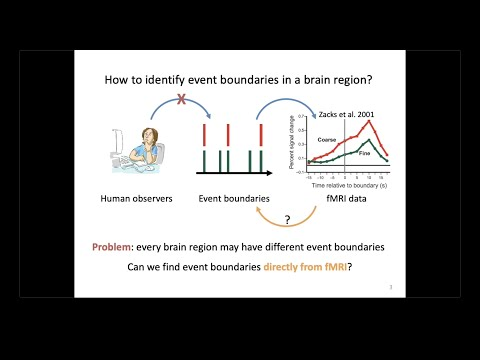

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('-iDMphdGVxo')

Next, [Dr. Linda Geerligs, PhD](https://lindageerligs.com/) an Assistant Professor at the Donders Institute, will discuss how the Greedy State Boundary Search can be used to segment events from brain activity.

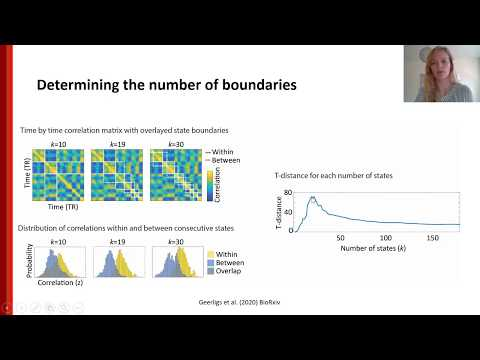

In [2]:
YouTubeVideo('KvwzjRtbJ6U')

## Getting Started
Before getting started with this tutorial, we need to make sure you have the necessary software installed and data downloaded.

### Software
This tutorial requires the following Python packages to be installed. See the [Software Installation](http://naturalistic-data.org/features/notebooks/Software.html) tutorial for more information.

- matplotlib
- pandas
- nltools
- nilearn
- datalad
- statesegmentation
- brainiak
- nibabel
- scipy

Now let's load the modules we will be using for this tutorial.

In [12]:
import warnings
import sys 
import os    
import glob
from statesegmentation import GSBS
from functools import reduce
import numpy as np
from brainiak.eventseg.event import EventSegment
import nibabel as nib
from nilearn.masking import apply_mask
from nltools.data import Brain_Data
from scipy.stats import zscore, norm
import datalad.api as dl

from matplotlib import pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

smallsize=14; mediumsize=16; largesize=18
plt.rc('xtick', labelsize=smallsize); plt.rc('ytick', labelsize=smallsize); plt.rc('legend', fontsize=mediumsize)
plt.rc('figure', titlesize=largesize); plt.rc('axes', labelsize=mediumsize); plt.rc('axes', titlesize=mediumsize)

### Data
This tutorial will be using the **Sherlock** dataset and will require downloading the cropped & denoised **.nii.gz** files. The tutorial will be mostly working with spatial patterns within the angular gyrus, so if you would like to get started with the tutorial right away without waiting for all of the nifti files to load, you can download the masked data as a `.npy` file from [figshare: Sherlock data for OHBM](https://figshare.com/articles/Sherlock_data_for_OHBM/12436955). 

You will want to change `data_dir` to wherever you have installed the Sherlock datalad repository. We will initialize a datalad dataset instance and get the files we need for this tutorial. If you've already downloaded everything, you can skip this cell. See the [Download Data Tutorial](http://naturalistic-data.org/features/notebooks/Download_Data.html) for more information about how to install and use datalad.

In [ ]:
data_dir = '/Volumes/Emily_MyPassport2TB/Sherlock/'

# If dataset hasn't been installed, clone from GIN repository
if not os.path.exists(data_dir):
    dl.clone(source='https://gin.g-node.org/ljchang/Sherlock', path=data_dir)

# Initialize dataset
ds = dl.Dataset(data_dir)

# Get Denoised nifti Files
result = ds.get(glob.glob(os.path.join(data_dir, 'fmriprep', '*', 'func', f'*denoise*nii.gz')))

### 0. Load Angular Gyrus data

From the angular gyrus (area PG from (Eickhoff et al., 2005)), we'll load movie data from all subjects, and recall data from one subject. Subjects were watching the first hour of [A Study in Pink](https://en.wikipedia.org/wiki/A_Study_in_Pink) (here we are loading only the first half of this data), and then freely recalled the narrative. Please refer to [Chen et al. (2017)](https://doi.org/10.1038/nn.4450) to learn more about this dataset.

We can load this data from the nii files by applying an angular gyrus mask, which we then cache into a numpy file to speed up loading in the future. If you'd like to skip this nii-loading step (which can be slow), you can download the npy files from [figshare: Sherlock data for OHBM](https://figshare.com/articles/Sherlock_data_for_OHBM/12436955).

In [19]:
mask = Brain_Data('https://neurovault.org/media/images/8423/AG_mask.nii.gz').to_nifti()

if (not os.path.exists(data_dir + 'Sherlock_AG_movie.npy') or
    not os.path.exists(data_dir + 'Sherlock_AG_recall.npy')):
    movie = []

    print('Cached data not found, loading from nii files')
    for sub in range(1,17):
        print('   Loading sub-%02d...' % sub)
        movie.append(apply_mask(os.path.join(data_dir, 'fmriprep','sub-%02d' % sub, 'func', \
                               'sub-%02d_denoise_smooth6mm_task-sherlockPart1_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz' % sub),
                               mask))
        if sub == 7:
            recall = apply_mask(os.path.join(data_dir, 'fmriprep','sub-%02d' % sub, 'func', \
                               'sub-%02d_denoise_smooth6mm_task-freerecall_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz' % sub),
                               mask)

    valid_vox = reduce(np.union1d, [np.where(np.std(m, axis=0)>0)[0] for m in movie])
    movie = [m[:,valid_vox] for m in movie]
    recall = recall[:487,valid_vox]  # Recall of 1st half of movie takes 487 TRs 
    np.save('Sherlock_AG_movie.npy', movie)
    np.save('Sherlock_AG_recall.npy', recall)

    
movie = np.load(os.path.join(data_dir, 'Sherlock_AG_movie.npy'))
recall = np.load(os.path.join(data_dir, 'Sherlock_AG_recall.npy'))
movie_group = np.mean(movie, axis=0)

### 1. Finding event boundaries during perception

#### 1.0 Warm-up: Event structure in activity patterns

Before applying any model, a good first step is to plot the correlation between activity patterns for each pair of timepoints during the movie. In this dataset, this shows blocks along the diagonal, which indicates that activity patterns are remaining stable for periods of tens of timepoints. This is the kind of structure that the HMM and GSBS models will be looking for.

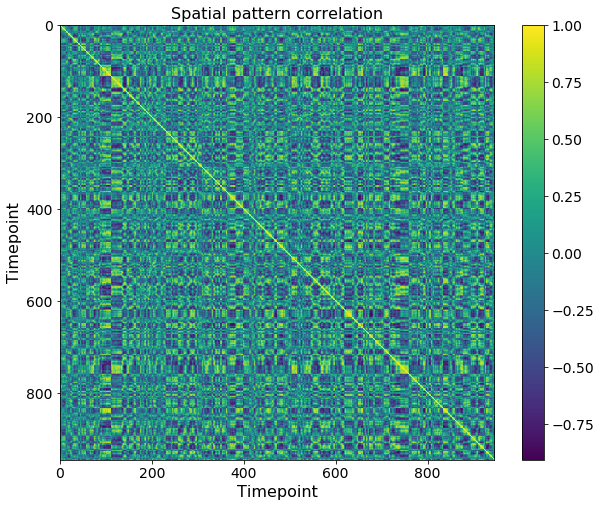

In [20]:
plt.figure(figsize=(10,8))
plt.imshow(np.corrcoef(movie_group))
plt.xlabel('Timepoint')
plt.ylabel('Timepoint')
plt.colorbar()
plt.title('Spatial pattern correlation');

#### 1.1 Fitting the HMM

To use an HMM to find both the event timings and the patterns corresponding to each event, we can use the EventSegment class from the brainiak toolbox. We need to specify the number of events, which here we set to 29 (corresponding to the number of boundaries typically annotated by human subjects).

In [21]:
movie_HMM = EventSegment(n_events = 29)
movie_HMM.fit(movie_group);

This fit produces:
* The log-likelihood (measuring overall model fit) over training. (Note that the log-likelihood on held-out test data is often a better measure of model quality - see below).
* The mean voxel pattern for each event. Here we show only 1% of the voxels since the ROI is large.
* A matrix showing the probability of being in each event at each timepoint. We can use this to derive the most likely timepoints where boundaries occur, and plot these on top of the timepoint similarity matrix for comparison.

Text(0.5, 0, 'Model fitting steps')

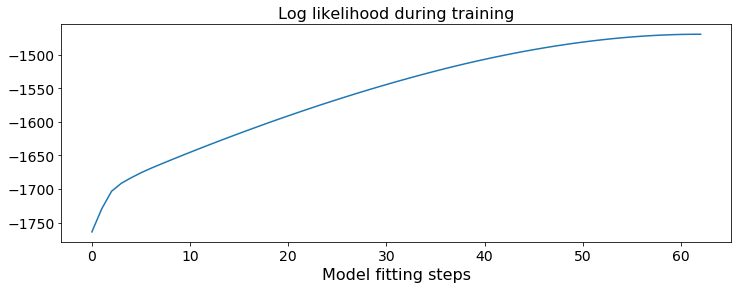

In [22]:
# Plotting the log-likelihood (measuring overall model fit)
plt.figure(figsize = (12, 4))
plt.plot(movie_HMM.ll_)
plt.title('Log likelihood during training')
plt.xlabel('Model fitting steps')

Text(0, 0.5, 'Voxels')

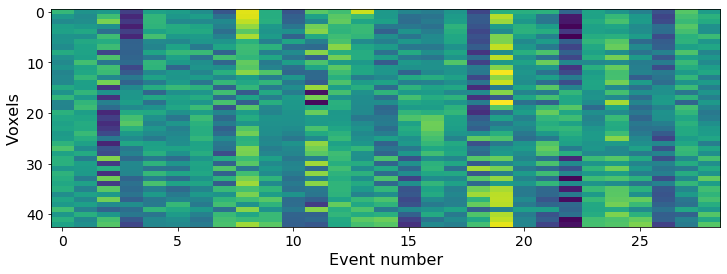

In [23]:
# Plotting mean activity in each event for some example voxels
plt.figure(figsize = (12, 4))
example_vox = np.arange(0,movie_HMM.event_pat_.shape[0],100)
plt.imshow(movie_HMM.event_pat_[example_vox,:], aspect='auto')
plt.xlabel('Event number')
plt.ylabel('Voxels')

Text(0.5, 1.05, 'Event probability')

<Figure size 864x432 with 0 Axes>

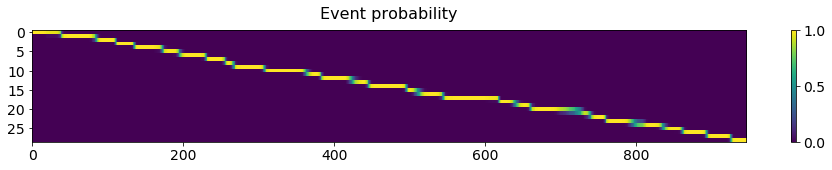

In [24]:
# Plot probability of being in each event at each timepoint
plt.figure(figsize = (12, 6))
plt.matshow(movie_HMM.segments_[0].T, aspect='auto')
plt.gca().xaxis.tick_bottom()
plt.colorbar()
plt.title('Event probability')

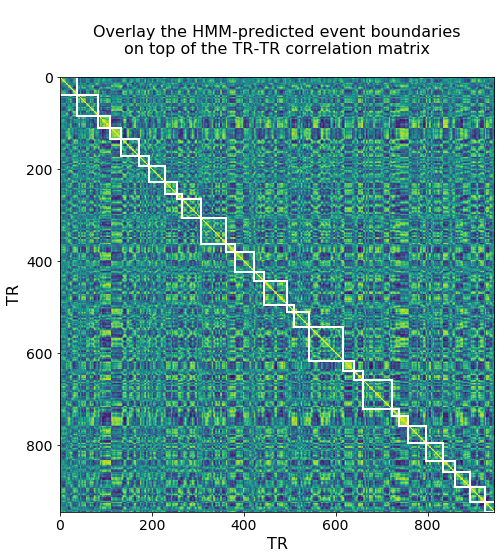

In [25]:
# Identify event boundaries as timepoints when max probability switches events
event_bounds = np.where(np.diff(np.argmax(movie_HMM.segments_[0], axis = 1)))[0]
nTRs = movie_group.shape[0]


# Plot boundaries as boxes on top of timepoint correlation matrix
def plot_tt_similarity_matrix(ax, data_matrix, bounds, n_TRs, title_text):
    
    ax.imshow(np.corrcoef(data_matrix), cmap = 'viridis')
    ax.set_title(title_text)
    ax.set_xlabel('TR')
    ax.set_ylabel('TR')
    
    # plot the boundaries 
    bounds_aug = np.concatenate(([0], bounds, [n_TRs]))
    
    for i in range(len(bounds_aug) - 1):
        rect = patches.Rectangle(
            (bounds_aug[i], bounds_aug[i]),
            bounds_aug[i+1] - bounds_aug[i],
            bounds_aug[i+1] - bounds_aug[i],
            linewidth = 2, edgecolor = 'w',facecolor = 'none'
        )
        ax.add_patch(rect)


f, ax = plt.subplots(1,1, figsize = (10,8))
title_text = '''
Overlay the HMM-predicted event boundaries
on top of the TR-TR correlation matrix
'''
plot_tt_similarity_matrix(ax, movie_group, event_bounds, nTRs, title_text)

#### 1.2 Determining the number of events with the HMM

What if we don't want to prespecify the number of events, but instead want to determine the number of events from the data? One way to determine the best number of events is to fit the model on a training set and then test the model fit on independent subjects.

In [26]:
k_array = np.arange(20, 61, 10)
test_ll = np.zeros(len(k_array))

for i, k in enumerate(k_array):
    print('Trying %d events' % k)
    
    print('   Fitting model on training subjects...')
    movie_train = np.mean(movie[:8], axis = 0)
    movie_HMM = EventSegment(k)
    movie_HMM.fit(movie_train)
    
    print('   Testing model fit on held-out subjects...')
    movie_test = np.mean(movie[8:], axis = 0)
    _, test_ll[i] = movie_HMM.find_events(movie_test)

Trying 20 events
   Fitting model on training subjects...
   Testing model fit on held-out subjects...
Trying 30 events
   Fitting model on training subjects...
   Testing model fit on held-out subjects...
Trying 40 events
   Fitting model on training subjects...
   Testing model fit on held-out subjects...
Trying 50 events
   Fitting model on training subjects...
   Testing model fit on held-out subjects...
Trying 60 events
   Fitting model on training subjects...
   Testing model fit on held-out subjects...


/Users/finnes/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


Text(0.5, 0, 'Average event length (sec)')

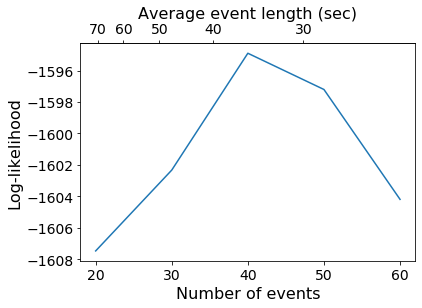

In [27]:
plt.plot(k_array, test_ll)
plt.xlabel('Number of events')
plt.ylabel('Log-likelihood')

movie_dur = nTRs * 1.5  # Data acquired every 1.5 seconds
secax = plt.gca().secondary_xaxis('top', functions=(lambda x: movie_dur / x, lambda x: movie_dur / x))
secax.set_xlabel('Average event length (sec)')

#### 1.3 Optimal segmentation with the HMM
Since 40 events maximized the test log-likelihood, we'll generate two versions of HMM boundaries using 40 events. In addition to the "vanilla" HMM, we'll run an HMM with more flexibility during fitting (allowing for split-merge operations). This is slower (and so should usually only be used for generating a final segmentation), but can produce better fits if events are very uneven in duration. We will use these segmentations below for comparison with an alternative event segmentation method (GSBS) and with human labeled event boundaries.

In [28]:
print('Fitting HMM with 40 events...')
HMM40 = EventSegment(n_events = 40)
HMM40.fit(movie_group)
HMM40_bounds = np.where(np.diff(np.argmax(HMM40.segments_[0], axis = 1)))[0]

print('Fitting split-merge HMM with 40 events...')
HMM40_SM = EventSegment(n_events = 40, split_merge = True)
HMM40_SM.fit(movie_group)
HMM40_SM_bounds = np.where(np.diff(np.argmax(HMM40_SM.segments_[0], axis = 1)))[0]

Fitting HMM with 40 events...
Fitting split-merge HMM with 40 events...


#### 1.4 Finding event boundaries with GSBS
GSBS is an alternative approach to finding both the event timings and the patterns corresponding to each event. The approach relies on a greedy search algorithm. To apply this algorithm, we can use the GSBS class from the statesegmentation toolbox. To determine the optimal number of event boundaries, GSBS uses the t-distance metric. T-distance relies on maximizing the similarity between timepoints that are part of the same event, while also minimizing the similarity between timepoints that are part of distinct but neighboring events. While t-distance can be optimized using cross-validation, like we did before for the log-likelihood, simulations showed that it performs best when the data are averaged across participants. 

To run GSBS and find the optimal number of states, we need to specify the maximal number of events, which here we set to 140 to reduce computational time, but could be set equal to the number of timepoints for a complete search through all possible number of states.

The following cell will take a little while to run (~15min, depending on your computer specs).

In [ ]:
GSBS_states = GSBS(x = movie_group, kmax = 140)
GSBS_states.fit()

This fit produces:

* The t-distance which is used to derive the optimal number of states
* The boundaries and mean voxel patterns for each event. We can obtain this both for the optimal number of states, as well as for each possible number of states lower than (or equal to) the maximal number of states we specified. 
* The strength of each event boundary, as quantified by the correlation distance. This is a measure of the dissimilarity between consecutive states

The optimal number of events is 109


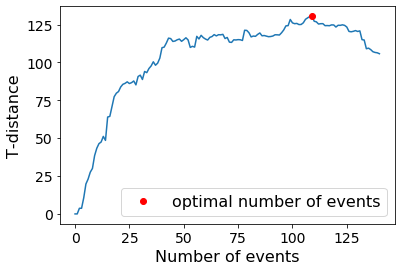

In [31]:
# Plotting the t-distance that is used to determine the optimal number of events

print('The optimal number of events is ' + str(GSBS_states.nstates))

plt.plot(GSBS_states.tdists)
plt.xlabel('Number of events')
plt.ylabel('T-distance')
plt.plot(GSBS_states.nstates, GSBS_states.tdists[GSBS_states.nstates], 'ro', label= 'optimal number of events')
plt.legend()


GSBS detects event boundaries in an iterative fashion. Boundaries that are detected first, also tend to show the largest change in voxel activity patterns between the corresponding events. We can measure this change in voxel activity patterns using the correlation distance. 

Text(0, 0.5, 'Correlation distance')

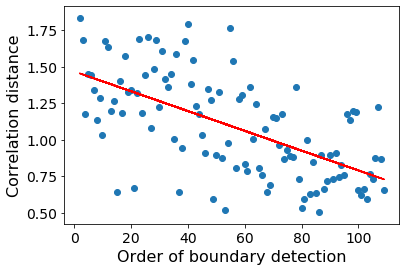

In [32]:
#GSBS boundary order vs. strength

#obtaining GSBS event bounds for the optimal number of events
GSBS_bounds = np.where(GSBS_states.deltas)[0]
x=GSBS_states.bounds[GSBS_bounds]
y=GSBS_states.strengths[GSBS_bounds]

plt.scatter(x, y)
b,m=np.polynomial.polynomial.polyfit(x,y,1)
plt.plot(x,b+m*x, 'r')
plt.xlabel('Order of boundary detection')
plt.ylabel('Correlation distance')

Text(0.5, 1.0, 'mean activity in the first 25 events for some example voxels')

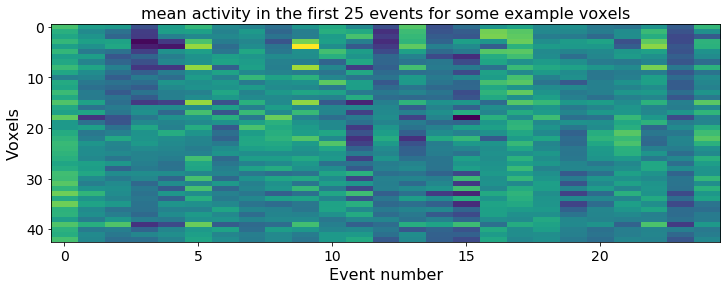

In [33]:
# Plotting mean activity in the first 25 events for some example voxels
plt.figure(figsize = (12, 4))
example_vox = np.arange(0,GSBS_states.state_patterns.shape[1],100)
plt.imshow(GSBS_states.state_patterns[0:25,example_vox].T, aspect='auto')
plt.xlabel('Event number')
plt.ylabel('Voxels')
plt.title('mean activity in the first 25 events for some example voxels')

We can visually compare the HMM and GSBS fits by plotting them on top of the timepoint correlation matrix. Since the optimal number of events selected by the two models is quite different, we also create a 40-event version of the GSBS bounds and a 109-event version of the HMM (and split-merge HMM) bounds for comparison. We zoom in on just the first 200 timepoints to allow for easier visualization.

In [34]:
#obtaining GSBS event bounds for 40 events (for comparison with the HMM)
GSBS40_bounds = np.where(GSBS_states.get_deltas(40))[0]

#obtaining HMM event bounds for 109 events (for comparison with the GSBS)
print('Fitting HMM with 109 events...')
HMM109 = EventSegment(n_events = 109)
HMM109.fit(movie_group)
HMM109_bounds = np.where(np.diff(np.argmax(HMM109.segments_[0], axis = 1)))[0]

print('Fitting split-merge HMM with 109 events...')
HMM109_SM = EventSegment(n_events = 109, split_merge = True)
HMM109_SM.fit(movie_group)
HMM109_SM_bounds = np.where(np.diff(np.argmax(HMM109_SM.segments_[0], axis = 1)))[0]

Fitting HMM with 109 events...
Fitting split-merge HMM with 109 events...


[0, 200, 0, 200]

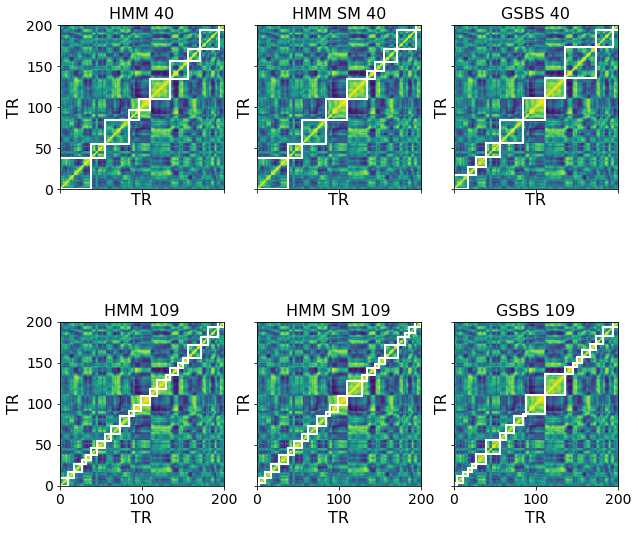

In [35]:
f, axes = plt.subplots(2,3, figsize = (10,10), sharex=True, sharey = True)
plot_tt_similarity_matrix(axes[0,0], movie_group, HMM40_bounds, nTRs, 'HMM 40')
plot_tt_similarity_matrix(axes[0,1], movie_group, HMM40_SM_bounds, nTRs, 'HMM SM 40')
plot_tt_similarity_matrix(axes[0,2], movie_group, GSBS40_bounds, nTRs, 'GSBS 40')
plot_tt_similarity_matrix(axes[1,0], movie_group, HMM109_bounds, nTRs, 'HMM 109')
plot_tt_similarity_matrix(axes[1,1], movie_group, HMM109_SM_bounds, nTRs, 'HMM SM 109')
plot_tt_similarity_matrix(axes[1,2], movie_group, GSBS_bounds, nTRs, 'GSBS 109')

axes[0,0].axis([0, 200, 0, 200]); axes[0,2].axis([0, 200, 0, 200]); axes[1,2].axis([0, 200, 0, 200])
axes[0,1].axis([0, 200, 0, 200]); axes[1,1].axis([0, 200, 0, 200]); axes[1,0].axis([0, 200, 0, 200])

### 2. Quantitatively comparing model and human-labeled boundaries

We can also quantitatively compare the event boundaries between different models, or between a model to human-labeled event boundaries. Because there is some ambiguity in both the stimulus and the model about exactly which timepoint the transition occurs at, we will count two boundaries as being a "match" if they are within 3 TRs (4.5 seconds) of each other.

To determine whether the match is statistically significant, we generate permuted versions of the boundaries as a null model for comparison.

In [36]:
# Timepoints of event boundaries annotated by human raters
human_bounds = [
    26, 35, 56, 72, 86, 108, 131, 143, 157, 173, 192, 204, 
    226, 313, 362, 398, 505, 526, 533, 568, 616, 634, 678,
    696, 747, 780, 870, 890
]

P values for matches to Human bounds: 
HMM40=0.001398, HMM_SM40=0.000275, GSBS40=0.019417, HMM109=0.020840, HMM_SM109=0.014915,GSBS109=0.034652


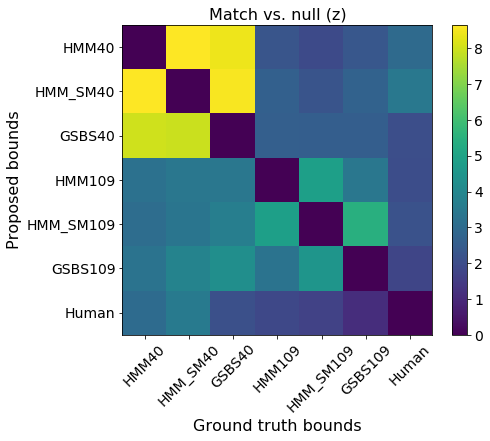

In [37]:
# Computes fraction of "ground truth" bounds are covered by a set of proposed bounds
# Returns z score relative to a null distribution via permutation
def match_z(proposed_bounds, gt_bounds, num_TRs):
    nPerm = 1000
    threshold = 3
    np.random.seed(0)

    gt_lengths = np.diff(np.concatenate(([0],gt_bounds,[num_TRs])))
    match = np.zeros(nPerm + 1)
    for p in range(nPerm + 1):
        gt_bounds = np.cumsum(gt_lengths)[:-1]
        for b in gt_bounds:
            if np.any(np.abs(proposed_bounds - b) <= threshold):
                match[p] += 1
        match[p] /= len(gt_bounds)
        gt_lengths = np.random.permutation(gt_lengths)
    
    return (match[0]-np.mean(match[1:]))/np.std(match[1:])

bound_types = [HMM40_bounds, HMM40_SM_bounds, GSBS40_bounds, HMM109_bounds, HMM109_SM_bounds, GSBS_bounds, human_bounds]
matchz_mat = np.zeros((len(bound_types), len(bound_types)))
for i, b1 in enumerate(bound_types):
    for j, b2 in enumerate(bound_types):
        if i != j:
            matchz_mat[i,j] = match_z(b1, b2, nTRs)


matchz_mat[np.diag(np.ones(7, dtype=bool))] = 0
f, ax = plt.subplots(1,1, figsize = (7,5.7))
a=plt.imshow(matchz_mat)
plt.colorbar()
plt.xticks(np.arange(0.5,7.5,1), ['HMM40', 'HMM_SM40','GSBS40', 'HMM109', 'HMM_SM109','GSBS109', 'Human'],rotation=45)
plt.yticks(np.arange(0.5,7.5,1), ['HMM40', 'HMM_SM40','GSBS40', 'HMM109', 'HMM_SM109','GSBS109', 'Human'])
plt.xlabel('Ground truth bounds')
plt.ylabel('Proposed bounds')
plt.title('Match vs. null (z)')
a.set_extent([0,7,7,0])

print('P values for matches to Human bounds: ')
print('HMM40=%f, HMM_SM40=%f, GSBS40=%f, HMM109=%f, HMM_SM109=%f,GSBS109=%f' % tuple(norm.sf(matchz_mat[:6,6]).tolist()))

These results show that all six sets of boundaries we generated are statistically significant matches to the human boundaries. It also appears that using the split-merge option in the HMM increases the HMM boundaries' similarity to both the human annotations as well as the GSBS boundaries.

### 3. Aligning movie and recall data

A simple model of free recall is that a subject will revisit the same sequence of events experienced during perception, but the lengths of the events will not be identical between perception and recall.

#### 3.1. Fit HMM on the two datasets  simultaneously

We use the same fit function as for a single dataset, but now we pass in both the movie and recall datasets in a list. We assume the two datasets have shared event transitions.

In [38]:
movie_recall_HMM = EventSegment(40)
movie_recall_HMM.fit([movie_group, recall]);

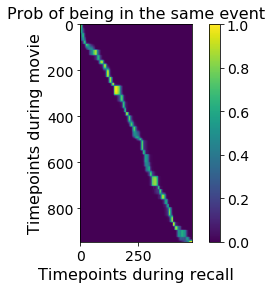

In [39]:
plt.imshow(movie_recall_HMM.segments_[0] @ movie_recall_HMM.segments_[1].T)
plt.xlabel('Timepoints during recall')
plt.ylabel('Timepoints during movie')
plt.colorbar()
plt.title('Prob of being in the same event');

#### 3.2 Define events from movie, find in recall

Alternatively, rather than finding events simultaneously in the movie and recall, we can first identify events using the movie data only, and then go looking for this fixed set of events in the recall. In this case we can use other methods, such as GSBS, to identify the events in the movie, and then use the HMM to transfer these events to the recall.

Below we do this for both the 40-event and 109-event segmentations from GSBS. Note that we need to specify a recall event variance for the HMM when applying it in this way - this value controls how confident the model is about whether it knows which event is being recalled given a spatial pattern. This parameter could be cross-validated relative to some other measure of performance, but here we just set the recall variance to be the same as the movie variance for each event.

In [40]:
# Use 40 GSBS events to set the HMM event patterns
n_events = 40
event_pat = GSBS_states.get_state_patterns(n_events).T
state_labels = GSBS_states.get_states(n_events)
movie_events40 = np.zeros((nTRs, np.max(state_labels)))
movie_events40[np.arange(nTRs), state_labels-1] = 1

HMM = EventSegment(n_events)
HMM.set_event_patterns(event_pat)
ev_var = HMM.calc_weighted_event_var(movie_group, movie_events40, HMM.event_pat_)
recall_events40 = HMM.find_events(recall, var = ev_var)[0]


# Use 109 GSBS events to set the HMM event patterns
n_events = GSBS_states.nstates
event_pat = GSBS_states.state_patterns.T
state_labels = GSBS_states.get_states()
movie_events109 = np.zeros((nTRs, np.max(state_labels)))
movie_events109[np.arange(nTRs), state_labels-1] = 1

HMM = EventSegment(n_events)
HMM.set_event_patterns(event_pat)
ev_var = HMM.calc_weighted_event_var(movie_group, movie_events109, HMM.event_pat_)
recall_events109 = HMM.find_events(recall, var = ev_var)[0]

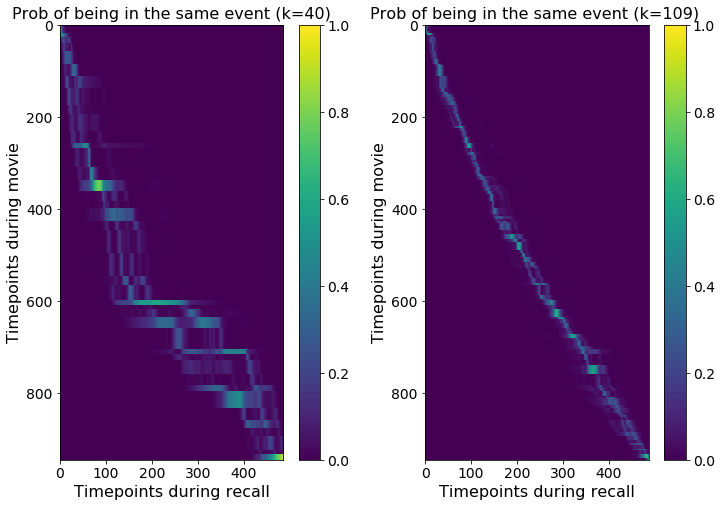

In [41]:
f = plt.figure( figsize = (12,8))
plt.subplot(1,2,1)
plt.imshow(movie_events40 @ recall_events40.T)
plt.xlabel('Timepoints during recall')
plt.ylabel('Timepoints during movie')
plt.colorbar()
plt.title('Prob of being in the same event (k=40)');

plt.subplot(1,2,2)
plt.imshow(movie_events109 @ recall_events109.T)
plt.xlabel('Timepoints during recall')
plt.ylabel('Timepoints during movie')
plt.colorbar()
plt.title('Prob of being in the same event (k=109) ');


Note that when fitting the model in this way (in which the recall data is not used to define the event patterns) you can obtain recall fits with multiple possible tracking paths, as can be seen in the K=40 plot.

## Recommended reading

* Baldassano, C., Hasson, U., & Norman, K. A. (2018). Representation of real-world event schemas during narrative perception. The Journal of Neuroscience: The Official Journal of the Society for Neuroscience, 38(45), 9689–9699. https://doi.org/10.1523/JNEUROSCI.0251-18.2018
    
* Geerligs L., van Gerven M., Güçlü U (2020) Detecting neural state transitions underlying event segmentation biorXiv. https://doi.org/10.1101/2020.04.30.069989
    

## Contributions

Chris Baldassano and Gordon Fleetwood developed the initial notebook.

Linda Geerligs added the GSBS method and edited section descriptions.

Emily Finn tested and lightly edited the notebook.